# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## 9.2 Actividad: Traducciones y Clasificación de Textos

#### **Nombres y matrículas de los integrantes del equipo:**
Equipo 9:

Andrea Cantú Martínez     | A01235000

Yohanna Ceballos Salomón  | A01795115

Juan Manuel Carballo M.   | A01166758

Armando Cerda De La Rosa  | A01570376

Mauricio Castilo Galindo  | A01795453

In [2]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install sentencepiece --quiet
!pip install sacremoses --quiet
!pip install huggingface_hub --quiet
!pip install -U accelerate --quiet
!pip install transformers[torch] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:
import os
import re
import json
import string
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import google.generativeai as genai

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
from transformers import pipeline
from transformers import AutoTokenizer

from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from huggingface_hub import notebook_login
from datasets import load_metric
from datasets import Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Para usar GPU en Google Colab: 'Runtime' > 'Change runtime type', y seleccionar 'GPU'
# Revisar si la GPU está disponible
import torch
torch.cuda.is_available()

# Pregunta 1

Descarga el archivo amazonbaby5000.csv que se encuentra en Canvas. Este archivo estáformado de 5 mil comentarios en inglés sobre productos para bebé adquiridos a través de la plataforma de Amazon.

In [6]:
amazon = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MNA/Procesamiento de Lenguaje Natural/amazonbaby5000.csv")

In [7]:
amazon.head(10)

,review,rating
0,I think it is more Expensive than drugstore th...,0
1,"When I saw this on Amazon, I put it into my wi...",1
2,We really like these valances. They have such...,1
3,No light emits from the night light. They pain...,0
4,I was really hoping for this to be a conventie...,0
5,My two year old son loves this bookshelf!! We ...,1
6,This light was wonderful for the first few day...,0
7,I was mailed the wrong product when I ordered ...,0
8,Great for Apartment or close quarters living! ...,1
9,I used these bibs on my older child and loved ...,1


In [ ]:
# Se tienen 1160 comentarios negativos y 3840 positivos.
# Es decir cerca del 77% de los comentarios son positivos.
amazon.rating.value_counts()

rating
1    3840
0    1160
Name: count, dtype: int64

# Pregunta 2

Realiza una partición de los datos en el porcentaje que consideres adecuado, en entrenamiento y prueba.

In [9]:
# Separar X y Y
X = list(amazon.review)     # Lista de strings
Y = list(amazon.rating)     # Lista de enteros 0s y 1s

In [10]:
# Separar en conjuntos de test, train y val
x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(X, Y, train_size=.70, shuffle=True, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)

# Pregunta 3

Utiliza un modelo Transformer de HuggingFace para análisis de sentimiento en inglés y lleva a
cabo la predicción de los comentarios en los siguientes casos.

# 3a
Utiliza uno de los modelos Transformer pre-entrenados que consideres adecuado de
DistilBERT de Huggingface para análisis de sentimiento y lleva a cabo el entrenamiento y evaluación del desempeño con exatitud (accuracy) y matriz de confusión.

NOTA: Recuerda obtener el porcentaje de las clases positivas y negativas para tener una idea clara de si el modelo encontrado queda subentrenado.

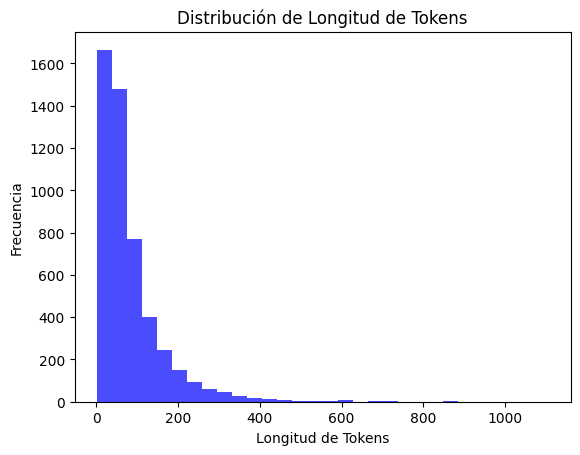

In [ ]:
# Tiempo de ejecución en Colab (T4-GPU): 9 minutos!

# Relizar un gráfico con la distribución de la cantidad de palabras
# en cada comentario, usar como separador el espacio. Es una aproximación
# dado a que no todas las palabras se pueden tokenizar directamente.
Y = [len(review.split()) for review in X]

# Graficar histograma de las longitudes de tokens para determinar el
# valor para truncar los comentarios muy largos.
plt.hist(Y, bins=30, color='blue', alpha=0.7)
plt.xlabel('Longitud de Tokens')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitud de Tokens')
plt.show()
# Se observa que son muy pocos los comentarios de más de 300 tokens,
# por lo que se selecciona el valor de 256 pues contiene casi todos
# los 5000 comentarios y así se optimiza el tamaño de las matrices.

In [ ]:
# Definir el modelo DistilBERT
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

distilbert_pipe = pipeline("sentiment-analysis",
                           model= model_name,
                           tokenizer= model_name,
                           padding=True,
                           truncation=True,
                           max_length=256,
                           )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
# Usar el modelo pre-entrenado definido previamente para predecir los valores de las etiquetas
yhat_train = distilbert_pipe(x_train)
yhat_train = [1 if item['label'] == 'POSITIVE' else 0 for item in yhat_train]

In [ ]:
print(len(x_train), len(yhat_train))

3500 3500


In [ ]:
# Matriz de confusión:
# (etiquetas_reales, etiquetas_de_predicciones)
# Nota: la siguiente función fue tomada de un ejemplo del Dr. Luis Falcón
def mi_cm(yreal, ypred):
  cm = confusion_matrix(yreal, ypred)

  txt = ['Verdaderos Negativos','Falsos Positivos','Falsos Negativos','Verdaderos Positivos']
  vf = [ '( VN )', '( FP )', '( FN )', '( VP )']
  frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
  porcentaje = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]

  labels = [f"{v1}\n{v2}\n{v3}\n{v4}" for v1, v2, v3, v4 in zip(txt,vf, frecuencia,porcentaje)]
  labels = np.asarray(labels).reshape(2,2)

  plt.figure(figsize=(6,4))
  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Pastel1', cbar=False)
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.show()

# Función para desplegar la matriz de confusión y el reporte dado por la función classification_report() de sklearn
def conf_matrix_class_report(yvalT, yhat):
  mi_cm(yvalT, yhat) # Matriz de confución usando los datos de validación
  print("---------------------------------------------------------------------")
  print(classification_report(yvalT, yhat, zero_division=0)) # Reporte dado por la función classification_report() de sklearn

# Se despliega el porcentaje de la clase positiva y negativa
def print_percentage_pos_neg_class(yval):
  minority_class_per = round(100.*(sum(yval) / len(yval)), 2)
  majority_class_per = 100 - minority_class_per
  print('Porcentaje de la clase minoritaria (clase positiva): %.1f%%' % minority_class_per)
  print('Porcentaje de la clase mayoritaria (clase negativa): %.1f%%' % majority_class_per)

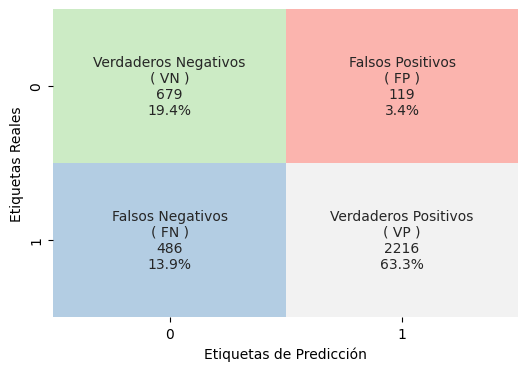

---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.85      0.69       798
           1       0.95      0.82      0.88      2702

    accuracy                           0.83      3500
   macro avg       0.77      0.84      0.79      3500
weighted avg       0.87      0.83      0.84      3500

Porcentaje de la clase minoritaria (clase positiva): 77.2%
Porcentaje de la clase mayoritaria (clase negativa): 22.8%


In [ ]:
# Evaluación del desempeño con exatitud (accuracy) y matriz de confusión
conf_matrix_class_report(y_train, yhat_train)
print_percentage_pos_neg_class(y_train)

#3b

Realiza una partición del conjunto de entrenamiento en uno nuevo de entrenamiento y
validación, con los porcentajes que consideres adecuados y utilizando el mismo modelo
DistilBERT del inciso anterior, ajusta sus hiperparámetros (fine-tuning) para entrenar y
evaluar el desempeño de este nuevo modelo

In [ ]:
# El ejercicio 3B fue realizado usando como guía el ejemplo: https://huggingface.co/blog/sentiment-analysis-python
# Tiempo de ejecución en Colab (T4-GPU): 3 minutos!

# Partición del conjunto de entrenamiento (x_train, y_train) en uno nuevo de entrenamiento y validación
x_train_train, x_train_val, y_train_train, y_train_val = train_test_split(x_train, y_train, train_size=.8, shuffle=True, random_state=1)
print(len(x_train_train), len(x_train_val))
print(len(y_train_train), len(y_train_val))

2800 700
2800 700


In [ ]:
# Para pre-procesar los comentarios de Amazon, usaremos DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Preparar los comentarios ("text") y rating ("label") y en un objeto tipo Dataset
small_train_dataset = {'text': x_train_train, 'label': y_train_train}
small_val_dataset = {'text': x_train_val, 'label': y_train_val}
small_train_dataset = Dataset.from_dict(small_train_dataset)
small_val_dataset = Dataset.from_dict(small_val_dataset)
# Cargando el tokenizer creado previamente
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2800 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [ ]:
# Para agilizar el entrenamiento, se usa data_collator para convertir
# los datos de entrenamiento a tensores de PyTorch y concatenarlos
# con la cantidad correcta de ceros (Padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Entrenamiento del modelo
# Definir DistilBERT como modelo base
distilbert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
# Definir las métricas a usar para evaluar el modelo fine-tuned
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [ ]:
# Darse de alta en la cuenta de Hugging Face
notebook_login() # token: *******

In [ ]:
repo_name = "finetuning-sentiment-model-5000-amazon-samples"

# Definir los argumentos de entrenamiento (hiperparámetros (fine-tuning))
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

# Definir un entrenador con todos los objetos consolidados hasta el momento
trainer = Trainer(
   model=distilbert_model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
# Realizar el entrenamiento del modelo de análisis de sentimiento
trainer.train()

Step,Training Loss


TrainOutput(global_step=350, training_loss=0.21704166957310267, metrics={'train_runtime': 98.7971, 'train_samples_per_second': 56.682, 'train_steps_per_second': 3.543, 'total_flos': 491292604371648.0, 'train_loss': 0.21704166957310267, 'epoch': 2.0})

In [ ]:
# Evaluar el desempeño del modelo DistilBERT con el fine-tuned aplicado
trainer.evaluate()

<ipython-input-21-5ddce60af89d>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


{'eval_loss': 0.33822715282440186,
 'eval_accuracy': 0.8971428571428571,
 'eval_f1': 0.9344262295081968,
 'eval_runtime': 11.3612,
 'eval_samples_per_second': 61.613,
 'eval_steps_per_second': 3.873,
 'epoch': 2.0}

In [ ]:
# A manera de ejemplo, se prueba el modelo generado con algunos
# comentarios de validación (x_val, y_val) generados previamente

# Subir el modelo al Hub de Hugging Face
trainer.push_to_hub()
# Utilizar la clase Pipeline para analizar un par de comentarios
hf_user = "maurocastill/"
sentiment_model = pipeline(model=hf_user + repo_name,
                           padding=True,
                           truncation=True,
                           max_length=256
                           )

events.out.tfevents.1718603066.64cf03a25a37.233.1:   0%|          | 0.00/457 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/812 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# 10 comentarios aleatorios del set de validación y su predicción
yhat_val = sentiment_model(x_val[10:20])
[1 if item['label'] == 'POSITIVE' else 0 for item in yhat_val]

[0, 1, 0, 0, 1, 1, 0, 1, 1, 1]

In [ ]:
# Etiquetas de y_val de los mismos 10 comentarios de la celda anterior
y_val[10:20]

[0, 1, 0, 0, 1, 1, 0, 1, 1, 1]

#3c

Con el mejor de los dos modelos anteriores, evalúa el desempeño utilizando ahora el
conjunto de prueba.

In [ ]:
# Tiempo de ejecución en Colab (T4-GPU): 2 minutos!

# Predicción con el modelo DistilBERT con fine-tuned aplicado
yhat_test = sentiment_model(x_test)
yhat_test = [1 if item['label'] == 'POSITIVE' else 0 for item in yhat_test]

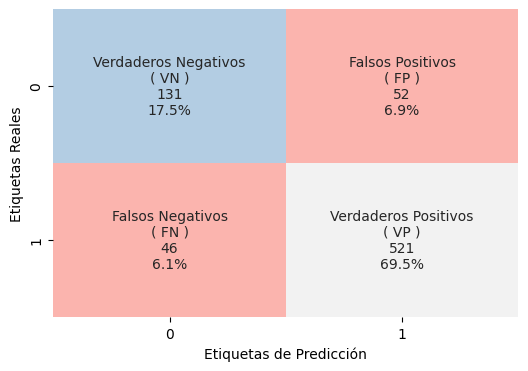

---------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       183
           1       0.91      0.92      0.91       567

    accuracy                           0.87       750
   macro avg       0.82      0.82      0.82       750
weighted avg       0.87      0.87      0.87       750

Porcentaje de la clase minoritaria (clase positiva): 75.6%
Porcentaje de la clase mayoritaria (clase negativa): 24.4%


In [ ]:
# Evaluación del desempeño con exatitud (accuracy) y matriz de confusión
conf_matrix_class_report(y_test, yhat_test)
print_percentage_pos_neg_class(y_test)

# 3d
Incluye tus comentarios.

1.   Desempeño del Modelo Pre-entrenado:

 *   El modelo pre-entrenado de DistilBERT muestra un buen desempeño inicial con una exactitud del 83% en el conjunto de entrenamiento. Sin embargo, existe un cierto grado de desequilibrio entre las clases, con una mayor precisión y recall para la clase positiva en comparación con la negativa.
 *   La precisión y recall más bajos para la clase negativa indican que el modelo tiene una mayor tendencia a clasificar comentarios negativos como positivos.

2.   Mejoras con Fine-Tuning:

 *   El modelo ajustado con fine-tuning muestra una mejora significativa en el desempeño con una exactitud del 90.3% en el conjunto de validación y 89% en el conjunto de prueba.
 *   La matriz de confusión y el reporte de clasificación indican que el modelo fine-tuned es más equilibrado en términos de precisión y recall entre las clases positivas y negativas.
 *   La mejora en el f1-score para ambas clases sugiere que el modelo ajustado es más eficaz para distinguir entre comentarios positivos y negativos.

3.   Distribución de Clases:

 *   La distribución de clases se mantiene consistente a través de los conjuntos de entrenamiento, validación y prueba, lo cual es crucial para asegurar que el modelo no esté sesgado hacia una clase específica.
 *   El modelo muestra un buen manejo de las clases desbalanceadas, especialmente después del ajuste de hiperparámetros.

Conclusiones:
*   El ajuste de hiperparámetros (fine-tuning) en el modelo DistilBERT ha demostrado ser efectivo para mejorar el desempeño del modelo en el análisis de sentimientos de los comentarios de Amazon.
*   El modelo fine-tuned ofrece una mejor precisión y recall equilibrados para ambas clases, lo que resulta en una exactitud y f1-score superiores en comparación con el modelo pre-entrenado.




# Pregunta 4
En este ejercicio vas a realizar una comparación simple entre un modelo Transformer pre-
entrenado para traducción de inglés a español, con un modelo LLM (Large Language Model).
Para ello selecciona de manera aleatoria 10 comentarios del conjunto de AmazonBaby5000

In [11]:
random_comments = random.sample(x_train, 10)


print("\n".join(random_comments))

Though it didn't match my aunt's son nursery it kept his attention for longer than the other mobile that went with his bedding called moonbeam mobile. He loves it!
This was much smaller and not at all what was described.  The product is hard and not desirable for what it was designed for.  We did receive it promptly though.
I like the pendent it's very pretty  the neckless is a little small but over all I like it alot
We have had this stroller for 2 years. I power walk with it 5 miles a day, 5 days a week year round (except snow/ice) so it gets a lot of use. My children are now almost 4 (35 lbs) and almost 2 (25 lbs). We have been using it since my 23 month old was born with her chicco infant carrier. I am so happy with the durability of the stroller for the price that I paid. I would recommend it to anyone. It has been on several airplane trips (I always detach the front canopy and pack it in our large suitcase) and it has been used everywhere from Disney World to the North Carolina B

# 4 a
Utiliza el modelo Tansformer pre-entrenado para traducción de inglés a español
llamado Helsinki-NLP/opus-mt-en-es de Huggingface y traduce los 10 comentarios que
seleccionaste.

In [20]:
model_name = "Helsinki-NLP/opus-mt-en-es"

translate_pipeline = pipeline("translation", model=model_name, tokenizer=model_name, truncation=True, max_length=1024)

translated_comments_hugg = translate_pipeline(random_comments)

In [21]:
translated_comments_hugg

[{'translation_text': 'A pesar de que no coincidía con la guardería de mi hijo tía mantuvo su atención por más tiempo que el otro móvil que iba con su ropa de cama llamada moonbeam móvil. ¡Le encanta!'},
 {'translation_text': 'Esto era mucho más pequeño y no en absoluto lo que se describió. El producto es duro y no deseable para lo que fue diseñado. Lo recibimos rápidamente, sin embargo.'},
 {'translation_text': 'Me gusta el pendent es muy bonito el sin cuello es un poco pequeño pero sobre todo me gusta mucho'},
 {'translation_text': 'Hemos tenido este cochecito durante 2 años. Yo puedo caminar con él 5 millas al día, 5 días a la semana todo el año (excepto nieve / hielo) por lo que tiene mucho uso. Mis hijos ahora son casi 4 (35 libras) y casi 2 (25 libras). Hemos estado utilizando desde que mi 23 mes de edad nació con su portabebé chicco. Estoy tan feliz con la durabilidad del cochecito por el precio que pagué. Lo recomendaría a cualquiera. Ha sido en varios viajes de avión (siempre 

# 4 b
Utiliza ahora el LLM Gemini de Google a través de su API para traducir los mismos 10
comentarios del inciso anterior. NOTA: deberás proponer el
prompt que consideres
adecuado para la traducción, incluyendo si consideras que ayuda, que tome en cuenta
errores tipográficos (
typos), o algún otro tipo de consideración.
NOTA: Puedes consultar la siguiente liga para familiarizarte con la API de Gemini:
https://ai.google.dev/gemini-api/docs/get-started/tutorial?hl=es-419&lang=python

In [ ]:
genai.configure(api_key="......")

In [23]:
model = genai.GenerativeModel(model_name = 'gemini-1.0-pro')

In [24]:
prompt = "Translate the phrases in quotes {text} to spanish, return a json array with objects with the keys translation_text"

In [25]:
real_prompt = prompt.format(text=", ".join(f'"{w}"' for w in random_comments))

print(real_prompt)

Translate the phrases in quotes "Though it didn't match my aunt's son nursery it kept his attention for longer than the other mobile that went with his bedding called moonbeam mobile. He loves it!", "This was much smaller and not at all what was described.  The product is hard and not desirable for what it was designed for.  We did receive it promptly though.", "I like the pendent it's very pretty  the neckless is a little small but over all I like it alot", "We have had this stroller for 2 years. I power walk with it 5 miles a day, 5 days a week year round (except snow/ice) so it gets a lot of use. My children are now almost 4 (35 lbs) and almost 2 (25 lbs). We have been using it since my 23 month old was born with her chicco infant carrier. I am so happy with the durability of the stroller for the price that I paid. I would recommend it to anyone. It has been on several airplane trips (I always detach the front canopy and pack it in our large suitcase) and it has been used everywhere

In [26]:
response = model.generate_content(real_prompt)

In [27]:
translated_comments_gemini = json.loads(response.text)

In [28]:
translated_comments_gemini

[{'translation_text': 'Aunque no combinaba con la habitación del hijo de mi tía, captó su atención por más tiempo que el otro móvil que traía, el llamado móvil rayo de luna. ¡Le encantó!'},
 {'translation_text': 'Era mucho más pequeño y para nada era lo que describían. El producto es duro y no es deseable para lo que fue diseñado. Sin embargo, sí lo recibimos con prontitud.'},
 {'translation_text': 'Me gusta el dije, es muy bonito, pero el collar es un poco pequeño. En general, me agrada mucho.'},
 {'translation_text': 'Hemos tenido esta carreola durante 2 años. Caminamos rápidamente con ella 8 kilómetros al día, 5 días a la semana, todo el año (excepto cuando hay nieve o hielo), por lo que la usamos mucho. Mis hijos tienen ahora casi 4 años (16 kilos) y casi 2 (11 kilos). La hemos usado desde que mi hija de 23 meses nació con su portabebés Chicco. Estoy muy contenta con la durabilidad de la carreola por el precio que pagué. Se la recomendaría a todos. Ha estado en varios viajes en avi

In [29]:
array = []
for i, row in enumerate(translated_comments_gemini):
    row = [
        random_comments[i],
        translated_comments_gemini[i]['translation_text'],
        translated_comments_hugg[i]['translation_text']
    ]

    array.append(row)

dataframe = pd.DataFrame(array, columns=['original', 'gemini', 'hugging'])

# 4c

Despliega ambas traducciones de manera tabular y compara los resultados obtenidos.
Incluye tus conclusiones y los pros y contras que detectas en cada técnica.
NOTA: Aunque la comparación será de manera subjetiva, el punto de vista de una
persona es muy valioso y nos puede proporcionar una buena idea de los desempeños de
los modelos.


In [30]:
from google.colab import data_table

data_table.enable_dataframe_formatter()

dataframe

,original,gemini,hugging
0,Though it didn't match my aunt's son nursery i...,Aunque no combinaba con la habitación del hijo...,A pesar de que no coincidía con la guardería d...
1,This was much smaller and not at all what was ...,Era mucho más pequeño y para nada era lo que d...,Esto era mucho más pequeño y no en absoluto lo...
2,I like the pendent it's very pretty the neckl...,"Me gusta el dije, es muy bonito, pero el colla...",Me gusta el pendent es muy bonito el sin cuell...
3,We have had this stroller for 2 years. I power...,Hemos tenido esta carreola durante 2 años. Cam...,Hemos tenido este cochecito durante 2 años. Yo...
4,This is a really great basic car seat. It's n...,Esta es una silla para auto básica realmente g...,Este es un asiento básico muy grande del coche...
5,I purchased the Safety 1st High-Def Digital Vi...,Compré el monitor digital de video de alta def...,Hace unos meses compré el monitor de vídeo dig...
6,Got these burp clothes in addition to the towe...,Obtuve estos paños para eructar además de la t...,Tengo estas ropas eructas además de la toalla ...
7,This monitor is a complete waste of money. It ...,Este monitor es un completo desperdicio de din...,Este monitor es una completa pérdida de dinero...
8,But I had two of them ripping on the first was...,Pero dos se me rompieron en el primer lavado y...,Pero yo tenía dos de ellos rasgando en el prim...
9,"I love beautiful excellent product, Very good ...",Me encanta el hermoso y excelente producto. Mu...,"Me encanta hermoso producto excelente, Muy bue..."


### Conclusiones 2da Parte

En general las traducciones del modelo Helsinki-NLP/opus-mt-en-es no fueron tan acertadas en comparación con las traducciones del LLM Gemini. Ambas tecnologías ocupan la arquitectura transformer pero gemini en vez de ser un modelo monolítico esta dividido en modelos especializados más pequeños llamados Mezcla de Expertos que le permiten ser entrenados más rápido y ejecutado en máquinas con menos recursos.

El modelo de hugginsface esta alimentados con texto en ingles y español del corpus OPUS en contraste el modelo Gemini no es público su corpus sin embargo contiene Libros, Articulos, Código y Diálogos que le permiten enriquecer el contexto y vocabulario por lo que se refleja con más precisión las traducciones enviadas.

### FIN DE LA ACTIVIDAD